## 1. Setup and Installation

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Define Feature Sets with Enhanced Categorization

In [7]:
# Integer features (must be rounded after SMOTE)
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases',
    'nadas', 'flaps'
]

# Heavy-tailed count features (benefit from log1p transform before SMOTE)
HEAVY_TAILED_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann',
    'number_rare_ases', 'nadas'
]

# Continuous features (can be float but bounded)
CONTINUOUS_FEATURES = [
    'edit_distance_avg',
    'rare_ases_avg'
]

# Bounded ratio features (need empirical min/max clipping)
BOUNDED_RATIO_FEATURES = [
    'rare_ases_avg'  # This is a ratio typically between 0 and 1
]

# Edit distance dict features (for constraint validation)
EDIT_DISTANCE_DICT_FEATURES = [
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6'
]

# Core features for quality validation
CORE_VALIDATION_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'edit_distance_avg'
]

# All features to use for synthetic generation
ALL_FEATURES = INTEGER_FEATURES + CONTINUOUS_FEATURES

# Columns to exclude (labels, timestamps, derived scores)
EXCLUDE_COLS = [
    'label', 'discovered_label', 'window_start', 'window_end',
    'iso_forest_score', 'lof_score', 'statistical_score',
    'elliptic_score', 'cluster', 'anomaly_votes', 'consensus_score'
]

# Potential grouping columns (if available in dataset)
POTENTIAL_GROUP_COLS = ['peer_asn', 'peer_ip', 'prefix', 'collector']

print(f"Integer features: {len(INTEGER_FEATURES)}")
print(f"Heavy-tailed features: {len(HEAVY_TAILED_FEATURES)}")
print(f"Continuous features: {len(CONTINUOUS_FEATURES)}")
print(f"Total features for generation: {len(ALL_FEATURES)}")

Integer features: 25
Heavy-tailed features: 5
Continuous features: 2
Total features for generation: 27


## 3. Load and Explore Data

In [8]:
# Load data - update the path as needed
DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv'

df = pd.read_csv(DATA_PATH)
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (86387, 38)


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,as_path_max,unique_as_path_max,edit_distance_avg,...,window_start,window_end,iso_forest_score,lof_score,statistical_score,elliptic_score,cluster,anomaly_votes,consensus_score,discovered_label
0,173,4,173,2,80,93,70,10,3,1.376471,...,2025-11-16 00:05:00,2025-11-16 00:05:01,-0.022727,-1.438412,0.129630,-690.140409,0,3.0,0.6,likely_anomaly
1,62,0,62,3,7,55,2,13,4,1.444444,...,2025-11-16 00:05:01,2025-11-16 00:05:02,0.121891,-1.245544,0.018519,3043.046687,0,0.0,0.0,likely_normal
2,9,4,9,0,5,4,0,9,2,3.000000,...,2025-11-16 00:05:02,2025-11-16 00:05:03,0.116573,-1.087356,0.018519,3105.127661,0,0.0,0.0,likely_normal
3,75,12,75,0,63,12,3,13,4,2.090909,...,2025-11-16 00:05:03,2025-11-16 00:05:04,0.125774,-1.198450,0.000000,3097.166097,0,0.0,0.0,likely_normal
4,101,24,101,17,41,60,15,10,4,1.408163,...,2025-11-16 00:05:04,2025-11-16 00:05:05,0.074830,-1.184218,0.185185,2797.657199,0,0.0,0.0,likely_normal


In [9]:
# Check label distributions
print("Discovered label distribution:")
print(df['discovered_label'].value_counts())
print("\nOriginal label distribution:")
print(df['label'].value_counts())

Discovered label distribution:
discovered_label
likely_normal              67940
uncertain                  11248
high_confidence_anomaly     5168
likely_anomaly              2031
Name: count, dtype: int64

Original label distribution:
label
normal    86387
Name: count, dtype: int64


In [10]:
# Filter only 'likely_normal' samples
df_likely_normal = df[df['discovered_label'] == 'likely_normal'].copy()
print(f"'likely_normal' samples: {len(df_likely_normal)}")

'likely_normal' samples: 67940


In [11]:
# Verify all features exist in the dataset
missing_features = [f for f in ALL_FEATURES if f not in df.columns]
if missing_features:
    print(f"WARNING: Missing features: {missing_features}")
else:
    print("All features found in dataset!")

All features found in dataset!


In [12]:
# Check for potential grouping columns
available_group_cols = [col for col in POTENTIAL_GROUP_COLS if col in df.columns]
print(f"Available grouping columns: {available_group_cols}")

if available_group_cols:
    for col in available_group_cols:
        n_unique = df_likely_normal[col].nunique()
        print(f"  {col}: {n_unique} unique values")

Available grouping columns: []


In [13]:
# Prepare features - use only raw BGP features
X_normal = df_likely_normal[ALL_FEATURES].copy()

# Handle any missing values
X_normal = X_normal.fillna(X_normal.median())

print(f"Feature matrix shape: {X_normal.shape}")
X_normal.describe()

Feature matrix shape: (67940, 27)


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
count,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,...,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000,67940.000000
mean,108.672211,5.771490,108.672211,2.182661,89.162555,19.393936,3.183721,4.641036,1.194569,3.446467,...,0.821681,0.224625,0.097895,1.500633,2.667883,37.406403,6.334575,1.740138,1.792607,0.144756
std,170.379033,12.067413,170.379033,4.019937,164.165984,28.412229,4.743217,5.400527,2.729516,4.481283,...,2.005170,0.765360,0.509667,2.542542,4.227160,31.561541,12.803703,3.349019,0.977686,0.114466
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.000000,21.000000,0.000000,11.000000,6.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,1.000000,0.000000,1.200000,0.069767
50%,44.000000,2.000000,44.000000,1.000000,25.000000,11.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,24.000000,3.000000,1.000000,1.755827,0.120567
75%,101.000000,7.000000,101.000000,2.000000,74.000000,22.000000,4.000000,6.000000,1.000000,5.000000,...,1.000000,0.000000,0.000000,2.000000,3.000000,53.000000,8.000000,2.000000,2.285714,0.179487
max,1379.000000,239.000000,1379.000000,51.000000,1333.000000,548.000000,70.000000,81.000000,46.000000,81.000000,...,41.000000,17.000000,19.000000,46.000000,55.000000,320.000000,232.000000,87.000000,12.000000,1.000000


In [14]:
# Store empirical bounds for all features (for clipping after inverse transform)
EMPIRICAL_BOUNDS = {}
for col in ALL_FEATURES:
    EMPIRICAL_BOUNDS[col] = {
        'min': X_normal[col].min(),
        'max': X_normal[col].max(),
        'q01': X_normal[col].quantile(0.01),
        'q99': X_normal[col].quantile(0.99)
    }

print("Empirical bounds computed for all features.")
print("\nExample bounds for key features:")
for feat in ['announcements', 'withdrawals', 'rare_ases_avg', 'edit_distance_avg']:
    print(f"  {feat}: [{EMPIRICAL_BOUNDS[feat]['min']:.4f}, {EMPIRICAL_BOUNDS[feat]['max']:.4f}]")

Empirical bounds computed for all features.

Example bounds for key features:
  announcements: [1.0000, 1379.0000]
  withdrawals: [0.0000, 239.0000]
  rare_ases_avg: [0.0000, 1.0000]
  edit_distance_avg: [0.0000, 12.0000]


## 4. Enhanced Preprocessing: Log1p Transform for Heavy-Tailed Features

In [15]:
def apply_log1p_transform(df, features):
    """
    Apply log1p transform to heavy-tailed features.
    This stabilizes SMOTE's neighborhood geometry and reduces unrealistic extremes.
    
    log1p(x) = log(1 + x), handles x=0 gracefully
    """
    result = df.copy()
    transform_info = {}
    
    for col in features:
        if col in result.columns:
            original_stats = {
                'mean': result[col].mean(),
                'std': result[col].std(),
                'skew': result[col].skew()
            }
            
            # Apply log1p transform
            result[col] = np.log1p(result[col])
            
            transformed_stats = {
                'mean': result[col].mean(),
                'std': result[col].std(),
                'skew': result[col].skew()
            }
            
            transform_info[col] = {
                'original': original_stats,
                'transformed': transformed_stats
            }
    
    return result, transform_info


def apply_expm1_inverse(df, features):
    """
    Apply inverse of log1p transform (expm1).
    expm1(x) = exp(x) - 1
    """
    result = df.copy()
    
    for col in features:
        if col in result.columns:
            result[col] = np.expm1(result[col])
    
    return result


# Demonstrate the effect of log1p transform
print("Effect of log1p transform on heavy-tailed features:")
print("="*70)

X_transformed, transform_info = apply_log1p_transform(X_normal.copy(), HEAVY_TAILED_FEATURES)

for col in HEAVY_TAILED_FEATURES[:3]:  # Show first 3
    info = transform_info[col]
    print(f"\n{col}:")
    print(f"  Original  - mean: {info['original']['mean']:.2f}, std: {info['original']['std']:.2f}, skew: {info['original']['skew']:.2f}")
    print(f"  Transformed - mean: {info['transformed']['mean']:.2f}, std: {info['transformed']['std']:.2f}, skew: {info['transformed']['skew']:.2f}")

Effect of log1p transform on heavy-tailed features:

announcements:
  Original  - mean: 108.67, std: 170.38, skew: 2.55
  Transformed - mean: 3.93, std: 1.17, skew: 0.50

withdrawals:
  Original  - mean: 5.77, std: 12.07, skew: 8.37
  Transformed - mean: 1.33, std: 1.00, skew: 0.51

nlri_ann:
  Original  - mean: 108.67, std: 170.38, skew: 2.55
  Transformed - mean: 3.93, std: 1.17, skew: 0.50


## 5. Enhanced Post-Processing with BGP Semantic Constraints

In [16]:
def post_process_synthetic(df, empirical_bounds=None, enforce_bgp_constraints=True):
    """
    Enhanced post-processing for synthetic data with:
    1. Integer rounding and non-negative constraints
    2. Empirical min/max clipping (not just >= 0)
    3. BGP semantic constraints enforcement
    
    Parameters:
    -----------
    df : pd.DataFrame
        Synthetic data to post-process
    empirical_bounds : dict
        Dictionary with min/max bounds for each feature
    enforce_bgp_constraints : bool
        Whether to enforce BGP domain-specific constraints
    """
    result = df.copy()
    
    # Step 1: Round integer features and ensure non-negative
    for col in INTEGER_FEATURES:
        if col in result.columns:
            result[col] = result[col].round().astype(int).clip(lower=0)
    
    # Step 2: Ensure continuous features are non-negative
    for col in CONTINUOUS_FEATURES:
        if col in result.columns:
            result[col] = result[col].clip(lower=0)
    
    # Step 3: Apply empirical bounds clipping (especially for bounded ratios)
    if empirical_bounds is not None:
        for col in BOUNDED_RATIO_FEATURES:
            if col in result.columns and col in empirical_bounds:
                bounds = empirical_bounds[col]
                result[col] = result[col].clip(
                    lower=bounds['min'],
                    upper=bounds['max']
                )
    
    # Step 4: Enforce BGP semantic constraints
    if enforce_bgp_constraints:
        result = enforce_bgp_semantic_constraints(result)
    
    return result


def enforce_bgp_semantic_constraints(df):
    """
    Enforce BGP-specific structural constraints on synthetic data.
    
    Constraints:
    1. nlri_ann <= announcements (NLRI count cannot exceed announcements)
    2. origin_0 + origin_2 <= announcements (origin types are subset of announcements)
    3. imp_wd_spath + imp_wd_dpath <= imp_wd (implicit withdrawals breakdown)
    4. edit_distance_dict sums should be consistent with edit_distance_max
    5. dups <= announcements (duplicates cannot exceed announcements)
    """
    result = df.copy()
    n_violations = {}
    
    # Constraint 1: nlri_ann <= announcements
    if 'nlri_ann' in result.columns and 'announcements' in result.columns:
        mask = result['nlri_ann'] > result['announcements']
        n_violations['nlri_ann > announcements'] = mask.sum()
        result.loc[mask, 'nlri_ann'] = result.loc[mask, 'announcements']
    
    # Constraint 2: origin_0 + origin_2 <= announcements
    if all(col in result.columns for col in ['origin_0', 'origin_2', 'announcements']):
        origin_sum = result['origin_0'] + result['origin_2']
        mask = origin_sum > result['announcements']
        n_violations['origin_0 + origin_2 > announcements'] = mask.sum()
        if mask.any():
            # Scale down proportionally
            scale_factor = result.loc[mask, 'announcements'] / origin_sum[mask]
            result.loc[mask, 'origin_0'] = (result.loc[mask, 'origin_0'] * scale_factor).round().astype(int)
            result.loc[mask, 'origin_2'] = (result.loc[mask, 'origin_2'] * scale_factor).round().astype(int)
    
    # Constraint 3: imp_wd_spath + imp_wd_dpath <= imp_wd
    if all(col in result.columns for col in ['imp_wd_spath', 'imp_wd_dpath', 'imp_wd']):
        imp_sum = result['imp_wd_spath'] + result['imp_wd_dpath']
        mask = imp_sum > result['imp_wd']
        n_violations['imp_wd_spath + imp_wd_dpath > imp_wd'] = mask.sum()
        if mask.any():
            scale_factor = result.loc[mask, 'imp_wd'] / imp_sum[mask].replace(0, 1)
            result.loc[mask, 'imp_wd_spath'] = (result.loc[mask, 'imp_wd_spath'] * scale_factor).round().astype(int)
            result.loc[mask, 'imp_wd_dpath'] = (result.loc[mask, 'imp_wd_dpath'] * scale_factor).round().astype(int)
    
    # Constraint 4: dups <= announcements
    if 'dups' in result.columns and 'announcements' in result.columns:
        mask = result['dups'] > result['announcements']
        n_violations['dups > announcements'] = mask.sum()
        result.loc[mask, 'dups'] = result.loc[mask, 'announcements']
    
    # Constraint 5: edit_distance_dict values should have max <= edit_distance_max
    if 'edit_distance_max' in result.columns:
        for ed_col in EDIT_DISTANCE_DICT_FEATURES:
            if ed_col in result.columns:
                # Individual edit distances shouldn't exceed max
                # (This is a soft constraint - edit_distance_dict_i represents count at distance i)
                pass  # This constraint is more complex and domain-specific
    
    # Report violations fixed
    total_violations = sum(n_violations.values())
    if total_violations > 0:
        print(f"\nBGP constraint violations fixed: {total_violations}")
        for constraint, count in n_violations.items():
            if count > 0:
                print(f"  {constraint}: {count}")
    
    return result


print("Post-processing functions defined!")

Post-processing functions defined!


## 6. k_neighbors Validation and Safe SMOTE Configuration

In [17]:
def validate_k_neighbors(n_samples, requested_k, method_name="SMOTE"):
    """
    Validate and adjust k_neighbors to avoid silent failures.
    
    SMOTE requires k_neighbors < number of minority samples.
    This function ensures safe k_neighbors selection and warns if adjusted.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples in the minority class
    requested_k : int
        Requested number of neighbors
    method_name : str
        Name of the method for logging
        
    Returns:
    --------
    int : Safe k_neighbors value
    """
    max_k = n_samples - 1
    
    if requested_k >= n_samples:
        safe_k = max(1, max_k)
        print(f"WARNING [{method_name}]: k_neighbors ({requested_k}) >= n_samples ({n_samples})")
        print(f"  Adjusting k_neighbors to {safe_k}")
        return safe_k
    
    return requested_k


def get_safe_smote_config(n_minority_samples, base_k=5):
    """
    Get safe SMOTE configuration based on available samples.
    
    Returns a dictionary with recommended parameters.
    """
    config = {
        'k_neighbors': validate_k_neighbors(n_minority_samples, base_k),
        'n_minority_samples': n_minority_samples,
        'is_safe': n_minority_samples >= 2  # Minimum for SMOTE
    }
    
    if not config['is_safe']:
        print(f"WARNING: Not enough minority samples ({n_minority_samples}) for SMOTE. Minimum is 2.")
    
    return config


# Test validation
print("Testing k_neighbors validation:")
print("="*50)
test_cases = [(100, 5), (10, 5), (5, 5), (3, 5), (2, 5)]
for n_samples, requested_k in test_cases:
    safe_k = validate_k_neighbors(n_samples, requested_k, "Test")
    print(f"  n_samples={n_samples}, requested_k={requested_k} -> safe_k={safe_k}")

Testing k_neighbors validation:
  n_samples=100, requested_k=5 -> safe_k=5
  n_samples=10, requested_k=5 -> safe_k=5
WARNING [Test]: k_neighbors (5) >= n_samples (5)
  Adjusting k_neighbors to 4
  n_samples=5, requested_k=5 -> safe_k=4
WARNING [Test]: k_neighbors (5) >= n_samples (3)
  Adjusting k_neighbors to 2
  n_samples=3, requested_k=5 -> safe_k=2
WARNING [Test]: k_neighbors (5) >= n_samples (2)
  Adjusting k_neighbors to 1
  n_samples=2, requested_k=5 -> safe_k=1


## 7. Enhanced SMOTE Generation Functions

In [18]:
def generate_with_smote_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced SMOTE generation with:
    - Log1p transform for heavy-tailed features
    - k_neighbors validation
    - Empirical bounds clipping
    - BGP constraint enforcement
    """
    n_original = len(X)
    
    # Step 1: Apply log1p transform if requested
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    # Step 2: Create artificial labels with validated minority size
    minority_size = max(10, int(n_original * 0.01))
    
    # Validate k_neighbors
    safe_k = validate_k_neighbors(minority_size, 5, "Standard SMOTE")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    # Step 3: Apply SMOTE with safe k_neighbors
    smote = SMOTE(
        sampling_strategy={1: desired_minority},
        k_neighbors=safe_k,
        random_state=random_state
    )
    
    X_resampled, y_resampled = smote.fit_resample(X_array, y)
    synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
    
    result = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    # Step 4: Apply inverse log transform if used
    if use_log_transform:
        result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
    
    # Step 5: Post-process with empirical bounds and BGP constraints
    result = post_process_synthetic(
        result, 
        empirical_bounds=EMPIRICAL_BOUNDS,
        enforce_bgp_constraints=enforce_constraints
    )
    
    return result

In [19]:
def generate_with_borderline_smote_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    kind='borderline-1',  # 'borderline-1' or 'borderline-2'
    random_state=42
):
    """
    Enhanced Borderline SMOTE generation.
    
    BorderlineSMOTE focuses on samples near the decision boundary,
    which may be useful for model training (not necessarily for traffic simulation).
    
    Parameters:
    -----------
    kind : str
        'borderline-1': Only oversample borderline samples
        'borderline-2': Also consider samples from majority class
    """
    n_original = len(X)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    minority_size = max(10, int(n_original * 0.01))
    safe_k = validate_k_neighbors(minority_size, 5, "Borderline SMOTE")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    borderline_smote = BorderlineSMOTE(
        sampling_strategy={1: desired_minority},
        k_neighbors=safe_k,
        m_neighbors=min(10, n_original - 1),
        kind=kind,
        random_state=random_state
    )
    
    X_resampled, y_resampled = borderline_smote.fit_resample(X_array, y)
    synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
    
    result = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    if use_log_transform:
        result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
    
    result = post_process_synthetic(
        result,
        empirical_bounds=EMPIRICAL_BOUNDS,
        enforce_bgp_constraints=enforce_constraints
    )
    
    return result

In [20]:
def generate_with_adasyn_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced ADASYN generation.
    Adaptively generates more samples in regions where density is low.
    """
    n_original = len(X)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    minority_size = max(10, int(n_original * 0.01))
    safe_k = validate_k_neighbors(minority_size, 5, "ADASYN")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    adasyn = ADASYN(
        sampling_strategy={1: desired_minority},
        n_neighbors=safe_k,
        random_state=random_state
    )
    
    try:
        X_resampled, y_resampled = adasyn.fit_resample(X_array, y)
        synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
        result = pd.DataFrame(synthetic_samples, columns=X.columns)
        
        if use_log_transform:
            result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
        
        result = post_process_synthetic(
            result,
            empirical_bounds=EMPIRICAL_BOUNDS,
            enforce_bgp_constraints=enforce_constraints
        )
        return result
    
    except ValueError as e:
        print(f"ADASYN failed: {e}. Falling back to standard SMOTE.")
        return generate_with_smote_enhanced(
            X, n_samples, use_log_transform, enforce_constraints, random_state
        )

In [21]:
def generate_with_kmeans_smote_enhanced(
    X, 
    n_samples, 
    n_clusters=10, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced K-Means clustering + SMOTE.
    Clusters the data first, then applies SMOTE within each cluster.
    """
    np.random.seed(random_state)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    X_array = X_work.values
    
    # Scale for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_array)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    cluster_sizes = np.bincount(cluster_labels)
    samples_per_cluster = (cluster_sizes / cluster_sizes.sum() * n_samples).astype(int)
    samples_per_cluster = np.maximum(samples_per_cluster, 1)
    
    synthetic_all = []
    
    for cluster_id in range(n_clusters):
        cluster_mask = cluster_labels == cluster_id
        X_cluster = X_array[cluster_mask]
        
        if len(X_cluster) < 3:
            continue
            
        n_to_generate = samples_per_cluster[cluster_id]
        minority_size = max(2, int(len(X_cluster) * 0.1))
        
        # Validate k_neighbors for this cluster
        safe_k = validate_k_neighbors(
            minority_size, 3, f"K-Means Cluster {cluster_id}"
        )
        
        if safe_k < 1:
            continue
            
        minority_idx = np.random.choice(len(X_cluster), minority_size, replace=False)
        
        y_cluster = np.zeros(len(X_cluster))
        y_cluster[minority_idx] = 1
        
        try:
            smote = SMOTE(
                sampling_strategy={1: n_to_generate + minority_size},
                k_neighbors=safe_k,
                random_state=random_state
            )
            X_res, y_res = smote.fit_resample(X_cluster, y_cluster)
            synthetic = X_res[y_res == 1][minority_size:]
            synthetic_all.append(synthetic)
        except Exception as e:
            print(f"  Cluster {cluster_id} failed: {e}")
            continue
    
    if synthetic_all:
        synthetic_combined = np.vstack(synthetic_all)
        result = pd.DataFrame(synthetic_combined[:n_samples], columns=X.columns)
        
        if use_log_transform:
            result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
        
        result = post_process_synthetic(
            result,
            empirical_bounds=EMPIRICAL_BOUNDS,
            enforce_bgp_constraints=enforce_constraints
        )
        return result
    else:
        print("K-Means SMOTE failed for all clusters. Falling back to standard SMOTE.")
        return generate_with_smote_enhanced(
            X, n_samples, use_log_transform, enforce_constraints, random_state
        )

## 8. Stratified SMOTE (Group-based Generation)

In [22]:
def generate_stratified_smote(
    df_full,
    feature_cols,
    group_col,
    n_samples,
    min_group_size=20,
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Stratified SMOTE: Apply SMOTE within subpopulations (e.g., by peer or prefix).
    
    This avoids mixing very different behaviors from different groups.
    
    Parameters:
    -----------
    df_full : pd.DataFrame
        Full dataframe with features and grouping column
    feature_cols : list
        List of feature column names
    group_col : str
        Column to group by (e.g., 'peer_asn', 'prefix')
    n_samples : int
        Total number of samples to generate
    min_group_size : int
        Minimum group size to apply SMOTE (smaller groups are skipped)
    """
    np.random.seed(random_state)
    
    # Get group sizes
    group_sizes = df_full.groupby(group_col).size()
    valid_groups = group_sizes[group_sizes >= min_group_size].index.tolist()
    
    print(f"Stratified SMOTE by '{group_col}':")
    print(f"  Total groups: {len(group_sizes)}")
    print(f"  Valid groups (>= {min_group_size} samples): {len(valid_groups)}")
    
    if len(valid_groups) == 0:
        print(f"  No valid groups found. Falling back to non-stratified SMOTE.")
        return generate_with_smote_enhanced(
            df_full[feature_cols], n_samples, use_log_transform, 
            enforce_constraints, random_state
        )
    
    # Calculate samples per group proportionally
    valid_sizes = group_sizes[valid_groups]
    samples_per_group = (valid_sizes / valid_sizes.sum() * n_samples).astype(int)
    samples_per_group = np.maximum(samples_per_group, 1)
    
    synthetic_all = []
    
    for group_id in valid_groups:
        group_df = df_full[df_full[group_col] == group_id]
        X_group = group_df[feature_cols].copy()
        n_to_generate = samples_per_group[group_id]
        
        if len(X_group) < 10:
            continue
        
        try:
            synthetic_group = generate_with_smote_enhanced(
                X_group, 
                n_to_generate,
                use_log_transform=use_log_transform,
                enforce_constraints=enforce_constraints,
                random_state=random_state + hash(str(group_id)) % 1000
            )
            synthetic_group[group_col] = group_id
            synthetic_all.append(synthetic_group)
        except Exception as e:
            print(f"  Group '{group_id}' failed: {e}")
            continue
    
    if synthetic_all:
        result = pd.concat(synthetic_all, ignore_index=True)
        print(f"  Generated {len(result)} samples across {len(synthetic_all)} groups")
        return result
    else:
        print("  All groups failed. Falling back to non-stratified SMOTE.")
        return generate_with_smote_enhanced(
            df_full[feature_cols], n_samples, use_log_transform,
            enforce_constraints, random_state
        )


print("Stratified SMOTE function defined!")

Stratified SMOTE function defined!


## 9. Distributional Validation Tests

In [23]:
def kolmogorov_smirnov_tests(original, synthetic, features=None, alpha=0.05):
    """
    Perform Kolmogorov-Smirnov tests to compare distributions.
    
    The KS test measures the maximum difference between the empirical
    cumulative distribution functions of two samples.
    
    Parameters:
    -----------
    original : pd.DataFrame
        Original data
    synthetic : pd.DataFrame
        Synthetic data
    features : list
        Features to test (default: core validation features)
    alpha : float
        Significance level
        
    Returns:
    --------
    pd.DataFrame : Results with KS statistic and p-value for each feature
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES
    
    results = []
    
    for col in features:
        if col in original.columns and col in synthetic.columns:
            ks_stat, p_value = ks_2samp(original[col], synthetic[col])
            
            results.append({
                'Feature': col,
                'KS Statistic': ks_stat,
                'P-Value': p_value,
                'Significant Diff': 'Yes' if p_value < alpha else 'No',
                'Quality': 'Good' if ks_stat < 0.1 else ('Fair' if ks_stat < 0.2 else 'Poor')
            })
    
    return pd.DataFrame(results)


def compare_correlation_matrices(original, synthetic, features=None):
    """
    Compare correlation matrices between original and synthetic data.
    
    This checks if SMOTE preserves the dependency structure, not just marginals.
    
    Returns:
    --------
    dict with correlation matrices and difference metrics
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES + ['origin_0', 'origin_2', 'dups']
    
    # Ensure features exist in both
    common_features = [f for f in features if f in original.columns and f in synthetic.columns]
    
    corr_original = original[common_features].corr()
    corr_synthetic = synthetic[common_features].corr()
    
    # Calculate difference metrics
    corr_diff = np.abs(corr_original - corr_synthetic)
    
    # Frobenius norm of difference (overall measure)
    frobenius_norm = np.sqrt((corr_diff ** 2).sum().sum())
    
    # Max absolute difference
    max_diff = corr_diff.values.max()
    
    # Mean absolute difference
    mean_diff = corr_diff.values.mean()
    
    return {
        'corr_original': corr_original,
        'corr_synthetic': corr_synthetic,
        'corr_diff': corr_diff,
        'frobenius_norm': frobenius_norm,
        'max_diff': max_diff,
        'mean_diff': mean_diff,
        'features': common_features
    }


def plot_correlation_comparison(corr_results, figsize=(16, 5)):
    """
    Plot correlation matrix comparison.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original correlation
    sns.heatmap(
        corr_results['corr_original'], 
        annot=True, fmt='.2f', cmap='coolwarm',
        center=0, vmin=-1, vmax=1,
        ax=axes[0]
    )
    axes[0].set_title('Original Data Correlation')
    
    # Synthetic correlation
    sns.heatmap(
        corr_results['corr_synthetic'], 
        annot=True, fmt='.2f', cmap='coolwarm',
        center=0, vmin=-1, vmax=1,
        ax=axes[1]
    )
    axes[1].set_title('Synthetic Data Correlation')
    
    # Difference
    sns.heatmap(
        corr_results['corr_diff'], 
        annot=True, fmt='.2f', cmap='Reds',
        vmin=0, vmax=0.5,
        ax=axes[2]
    )
    axes[2].set_title(f"Absolute Difference (Mean: {corr_results['mean_diff']:.3f})")
    
    plt.tight_layout()
    return fig


def plot_distribution_comparison(original, synthetic, features=None, figsize=(15, 10)):
    """
    Plot distribution comparisons for key features.
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES
    
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(features):
        ax = axes[i]
        
        # Plot histograms
        ax.hist(original[col], bins=50, alpha=0.5, label='Original', density=True)
        ax.hist(synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
        
        # Add KS statistic
        ks_stat, p_value = ks_2samp(original[col], synthetic[col])
        ax.set_title(f'{col}\nKS={ks_stat:.3f}, p={p_value:.3e}')
        ax.legend()
    
    # Hide unused axes
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig


print("Distributional validation functions defined!")

Distributional validation functions defined!


## 10. Enhanced Statistics Comparison

In [24]:
def compare_statistics_enhanced(original, synthetic, name):
    """
    Enhanced comparison with more metrics and all features.
    """
    print(f"\n{'='*70}")
    print(f"Enhanced Comparison: {name}")
    print(f"{'='*70}")
    
    results = []
    for col in ALL_FEATURES:
        if col not in original.columns or col not in synthetic.columns:
            continue
            
        orig_mean = original[col].mean()
        orig_std = original[col].std()
        orig_median = original[col].median()
        orig_skew = original[col].skew()
        
        synth_mean = synthetic[col].mean()
        synth_std = synthetic[col].std()
        synth_median = synthetic[col].median()
        synth_skew = synthetic[col].skew()
        
        mean_diff = abs(orig_mean - synth_mean) / (abs(orig_mean) + 1e-10) * 100
        std_diff = abs(orig_std - synth_std) / (abs(orig_std) + 1e-10) * 100
        median_diff = abs(orig_median - synth_median) / (abs(orig_median) + 1e-10) * 100
        
        # KS test
        ks_stat, ks_pval = ks_2samp(original[col], synthetic[col])
        
        results.append({
            'Feature': col,
            'Orig Mean': f'{orig_mean:.2f}',
            'Synth Mean': f'{synth_mean:.2f}',
            'Mean Diff %': f'{mean_diff:.1f}%',
            'Orig Std': f'{orig_std:.2f}',
            'Synth Std': f'{synth_std:.2f}',
            'Std Diff %': f'{std_diff:.1f}%',
            'KS Stat': f'{ks_stat:.3f}',
            'Quality': 'Good' if ks_stat < 0.1 else ('Fair' if ks_stat < 0.2 else 'Poor')
        })
    
    return pd.DataFrame(results)


print("Enhanced statistics comparison function defined!")

Enhanced statistics comparison function defined!


## 11. Generate Synthetic Data

In [25]:
# Configuration
N_SYNTHETIC = 20000  # Number of synthetic samples to generate
USE_LOG_TRANSFORM = True  # Apply log1p transform for heavy-tailed features
ENFORCE_BGP_CONSTRAINTS = True  # Enforce BGP semantic constraints

print(f"Configuration:")
print(f"  N_SYNTHETIC: {N_SYNTHETIC}")
print(f"  USE_LOG_TRANSFORM: {USE_LOG_TRANSFORM}")
print(f"  ENFORCE_BGP_CONSTRAINTS: {ENFORCE_BGP_CONSTRAINTS}")
print(f"\nGenerating synthetic samples...")

Configuration:
  N_SYNTHETIC: 20000
  USE_LOG_TRANSFORM: True
  ENFORCE_BGP_CONSTRAINTS: True

Generating synthetic samples...


In [26]:
# Method 1: Enhanced Standard SMOTE
print("\n" + "="*60)
print("Generating with Enhanced Standard SMOTE...")
print("="*60)

synthetic_smote = generate_with_smote_enhanced(
    X_normal, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_smote)} samples")
synthetic_smote.head()


Generating with Enhanced Standard SMOTE...



BGP constraint violations fixed: 3795
  origin_0 + origin_2 > announcements: 2780
  imp_wd_spath + imp_wd_dpath > imp_wd: 1015
Generated: 20000 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,22,7,22,2,13,9,0,3,2,1,...,0,0,0,2,1,21,1,2,0.748819,0.218928
1,13,1,13,0,6,7,2,2,1,1,...,0,0,0,1,1,18,6,1,0.892927,0.323296
2,629,1,629,0,612,17,1,1,0,1,...,0,0,0,0,0,108,7,1,1.976815,0.038756
3,37,7,37,6,22,15,2,8,2,6,...,2,1,0,3,2,17,1,7,1.665578,0.081749
4,15,3,15,0,8,7,1,0,0,0,...,0,0,0,0,0,22,1,3,1.820458,0.272190


In [27]:
# Method 2: Enhanced Borderline SMOTE
print("\n" + "="*60)
print("Generating with Enhanced Borderline SMOTE...")
print("="*60)

synthetic_borderline = generate_with_borderline_smote_enhanced(
    X_normal, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS,
    kind='borderline-1'
)
print(f"Generated: {len(synthetic_borderline)} samples")
synthetic_borderline.head()


Generating with Enhanced Borderline SMOTE...

BGP constraint violations fixed: 3462
  origin_0 + origin_2 > announcements: 2481
  imp_wd_spath + imp_wd_dpath > imp_wd: 981
Generated: 20000 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,606,0,606,0,586,20,2,4,0,3,...,0,2,0,0,2,85,1,0,2.658001,0.031225
1,112,7,112,2,87,24,17,7,1,6,...,1,2,0,1,8,37,3,3,1.917423,0.064126
2,12,2,12,2,7,5,2,3,1,2,...,0,0,0,1,1,6,5,0,0.762421,0.141321
3,64,7,64,2,55,9,6,7,1,6,...,1,0,0,2,6,37,8,3,1.508646,0.104452
4,23,2,23,3,16,7,3,3,1,2,...,0,0,0,2,4,20,1,1,1.671008,0.158040


In [28]:
# Method 3: Enhanced ADASYN
print("\n" + "="*60)
print("Generating with Enhanced ADASYN...")
print("="*60)

synthetic_adasyn = generate_with_adasyn_enhanced(
    X_normal, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_adasyn)} samples")
synthetic_adasyn.head()


Generating with Enhanced ADASYN...

BGP constraint violations fixed: 3691
  origin_0 + origin_2 > announcements: 2660
  imp_wd_spath + imp_wd_dpath > imp_wd: 1031
Generated: 20178 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,101,0,101,1,96,5,2,2,0,2,...,0,0,0,0,1,70,11,0,1.866002,0.177878
1,101,0,101,0,95,6,2,1,0,1,...,0,0,0,0,1,72,10,0,1.953817,0.180401
2,100,1,100,0,95,5,1,1,0,1,...,0,0,0,0,1,73,10,0,1.235712,0.184492
3,98,1,98,2,93,5,2,4,1,3,...,0,0,0,1,1,59,11,1,1.687499,0.156543
4,100,0,100,1,94,6,2,2,0,2,...,0,0,0,0,1,67,10,0,1.869565,0.172853


In [29]:
# Method 4: Enhanced K-Means SMOTE
print("\n" + "="*60)
print("Generating with Enhanced K-Means SMOTE...")
print("="*60)

synthetic_kmeans = generate_with_kmeans_smote_enhanced(
    X_normal, 
    N_SYNTHETIC,
    n_clusters=10,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_kmeans)} samples")
synthetic_kmeans.head()


Generating with Enhanced K-Means SMOTE...

BGP constraint violations fixed: 2852
  origin_0 + origin_2 > announcements: 1940
  imp_wd_spath + imp_wd_dpath > imp_wd: 912
Generated: 19994 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,582,0,582,2,566,15,1,2,2,0,...,0,0,0,2,0,90,2,0,0.575454,0.034275
1,374,12,374,0,360,14,1,0,0,0,...,1,0,0,0,0,103,10,1,2.662915,0.053007
2,698,10,698,2,670,28,6,6,1,5,...,3,1,0,2,4,116,12,4,1.930363,0.037396
3,647,3,647,3,570,77,2,4,2,2,...,2,0,0,2,2,95,7,2,1.685618,0.032015
4,600,1,600,0,587,13,0,0,0,0,...,0,0,0,0,0,96,9,0,2.290495,0.036419


In [30]:
# Method 5: Stratified SMOTE (if grouping column exists)
synthetic_stratified = None

if available_group_cols:
    print("\n" + "="*60)
    print(f"Generating with Stratified SMOTE (by '{available_group_cols[0]}')...")
    print("="*60)
    
    synthetic_stratified = generate_stratified_smote(
        df_likely_normal,
        ALL_FEATURES,
        available_group_cols[0],
        N_SYNTHETIC,
        min_group_size=20,
        use_log_transform=USE_LOG_TRANSFORM,
        enforce_constraints=ENFORCE_BGP_CONSTRAINTS
    )
    print(f"Generated: {len(synthetic_stratified)} samples")
else:
    print("\nNo grouping columns available. Skipping Stratified SMOTE.")


No grouping columns available. Skipping Stratified SMOTE.


## 12. Validation: Verify Data Types and Constraints

In [31]:
def validate_synthetic_data(synthetic_df, original_df, name):
    """
    Comprehensive validation of synthetic data.
    """
    print(f"\n{'='*60}")
    print(f"Validation: {name}")
    print(f"{'='*60}")
    
    issues = []
    
    # 1. Check integer features
    print("\n1. Integer Feature Validation:")
    for col in INTEGER_FEATURES[:5]:
        if col in synthetic_df.columns:
            is_int = (synthetic_df[col] == synthetic_df[col].astype(int)).all()
            min_val = synthetic_df[col].min()
            is_non_neg = min_val >= 0
            print(f"   {col}: int={is_int}, non-neg={is_non_neg}, min={min_val}")
            if not is_int:
                issues.append(f"{col} is not integer")
            if not is_non_neg:
                issues.append(f"{col} has negative values")
    
    # 2. Check BGP constraints
    print("\n2. BGP Constraint Validation:")
    
    # nlri_ann <= announcements
    if 'nlri_ann' in synthetic_df.columns and 'announcements' in synthetic_df.columns:
        violations = (synthetic_df['nlri_ann'] > synthetic_df['announcements']).sum()
        print(f"   nlri_ann <= announcements: {violations} violations")
        if violations > 0:
            issues.append(f"nlri_ann > announcements: {violations}")
    
    # origin_0 + origin_2 <= announcements
    if all(c in synthetic_df.columns for c in ['origin_0', 'origin_2', 'announcements']):
        violations = ((synthetic_df['origin_0'] + synthetic_df['origin_2']) > synthetic_df['announcements']).sum()
        print(f"   origin_0 + origin_2 <= announcements: {violations} violations")
        if violations > 0:
            issues.append(f"origin sum > announcements: {violations}")
    
    # dups <= announcements
    if 'dups' in synthetic_df.columns and 'announcements' in synthetic_df.columns:
        violations = (synthetic_df['dups'] > synthetic_df['announcements']).sum()
        print(f"   dups <= announcements: {violations} violations")
        if violations > 0:
            issues.append(f"dups > announcements: {violations}")
    
    # 3. Check empirical bounds for bounded ratios
    print("\n3. Empirical Bounds Validation:")
    for col in BOUNDED_RATIO_FEATURES:
        if col in synthetic_df.columns:
            orig_min, orig_max = original_df[col].min(), original_df[col].max()
            synth_min, synth_max = synthetic_df[col].min(), synthetic_df[col].max()
            within_bounds = (synth_min >= orig_min * 0.95) and (synth_max <= orig_max * 1.05)
            print(f"   {col}: orig=[{orig_min:.4f}, {orig_max:.4f}], synth=[{synth_min:.4f}, {synth_max:.4f}]")
            print(f"         within bounds (5% tolerance): {within_bounds}")
    
    # 4. Summary
    print(f"\n4. Summary:")
    if issues:
        print(f"   ISSUES FOUND: {len(issues)}")
        for issue in issues:
            print(f"     - {issue}")
    else:
        print("   All validations passed!")
    
    return len(issues) == 0


# Validate all methods
validate_synthetic_data(synthetic_smote, X_normal, "Enhanced Standard SMOTE")
validate_synthetic_data(synthetic_borderline, X_normal, "Enhanced Borderline SMOTE")
validate_synthetic_data(synthetic_adasyn, X_normal, "Enhanced ADASYN")
validate_synthetic_data(synthetic_kmeans, X_normal, "Enhanced K-Means SMOTE")


Validation: Enhanced Standard SMOTE

1. Integer Feature Validation:
   announcements: int=True, non-neg=True, min=3
   withdrawals: int=True, non-neg=True, min=0
   nlri_ann: int=True, non-neg=True, min=3
   dups: int=True, non-neg=True, min=0
   origin_0: int=True, non-neg=True, min=0

2. BGP Constraint Validation:
   nlri_ann <= announcements: 0 violations
   origin_0 + origin_2 <= announcements: 32 violations
   dups <= announcements: 0 violations

3. Empirical Bounds Validation:
   rare_ases_avg: orig=[0.0000, 1.0000], synth=[0.0095, 0.9162]
         within bounds (5% tolerance): True

4. Summary:
   ISSUES FOUND: 1
     - origin sum > announcements: 32

Validation: Enhanced Borderline SMOTE

1. Integer Feature Validation:
   announcements: int=True, non-neg=True, min=7
   withdrawals: int=True, non-neg=True, min=0
   nlri_ann: int=True, non-neg=True, min=7
   dups: int=True, non-neg=True, min=0
   origin_0: int=True, non-neg=True, min=1

2. BGP Constraint Validation:
   nlri_ann 

False

## 13. Distributional Tests

In [32]:
# 1D Tests: Kolmogorov-Smirnov
print("\n" + "="*70)
print("Kolmogorov-Smirnov Tests (1D Distributional Comparison)")
print("="*70)

ks_results_smote = kolmogorov_smirnov_tests(X_normal, synthetic_smote)
print("\nEnhanced Standard SMOTE:")
display(ks_results_smote)

ks_results_kmeans = kolmogorov_smirnov_tests(X_normal, synthetic_kmeans)
print("\nEnhanced K-Means SMOTE:")
display(ks_results_kmeans)


Kolmogorov-Smirnov Tests (1D Distributional Comparison)

Enhanced Standard SMOTE:


,Feature,KS Statistic,P-Value,Significant Diff,Quality
0,announcements,0.051721,2.310351e-36,Yes,Good
1,withdrawals,0.034435,2.364311e-16,Yes,Good
2,nlri_ann,0.051721,2.310351e-36,Yes,Good
3,edit_distance_avg,0.073042,3.939478e-72,Yes,Good



Enhanced K-Means SMOTE:


,Feature,KS Statistic,P-Value,Significant Diff,Quality
0,announcements,0.010948,4.891888e-02,Yes,Good
1,withdrawals,0.027401,1.648800e-10,Yes,Good
2,nlri_ann,0.010948,4.891888e-02,Yes,Good
3,edit_distance_avg,0.053703,3.660216e-39,Yes,Good


In [33]:
# 2D Tests: Correlation Matrix Comparison
print("\n" + "="*70)
print("Correlation Matrix Comparison (2D Dependency Structure)")
print("="*70)

corr_results_smote = compare_correlation_matrices(X_normal, synthetic_smote)
print(f"\nEnhanced Standard SMOTE:")
print(f"  Frobenius Norm of Difference: {corr_results_smote['frobenius_norm']:.4f}")
print(f"  Max Absolute Difference: {corr_results_smote['max_diff']:.4f}")
print(f"  Mean Absolute Difference: {corr_results_smote['mean_diff']:.4f}")

corr_results_kmeans = compare_correlation_matrices(X_normal, synthetic_kmeans)
print(f"\nEnhanced K-Means SMOTE:")
print(f"  Frobenius Norm of Difference: {corr_results_kmeans['frobenius_norm']:.4f}")
print(f"  Max Absolute Difference: {corr_results_kmeans['max_diff']:.4f}")
print(f"  Mean Absolute Difference: {corr_results_kmeans['mean_diff']:.4f}")


Correlation Matrix Comparison (2D Dependency Structure)

Enhanced Standard SMOTE:
  Frobenius Norm of Difference: 0.2091
  Max Absolute Difference: 0.1049
  Mean Absolute Difference: 0.0178

Enhanced K-Means SMOTE:
  Frobenius Norm of Difference: 0.0860
  Max Absolute Difference: 0.0270
  Mean Absolute Difference: 0.0097



Correlation Matrix Comparison Plot (Standard SMOTE):


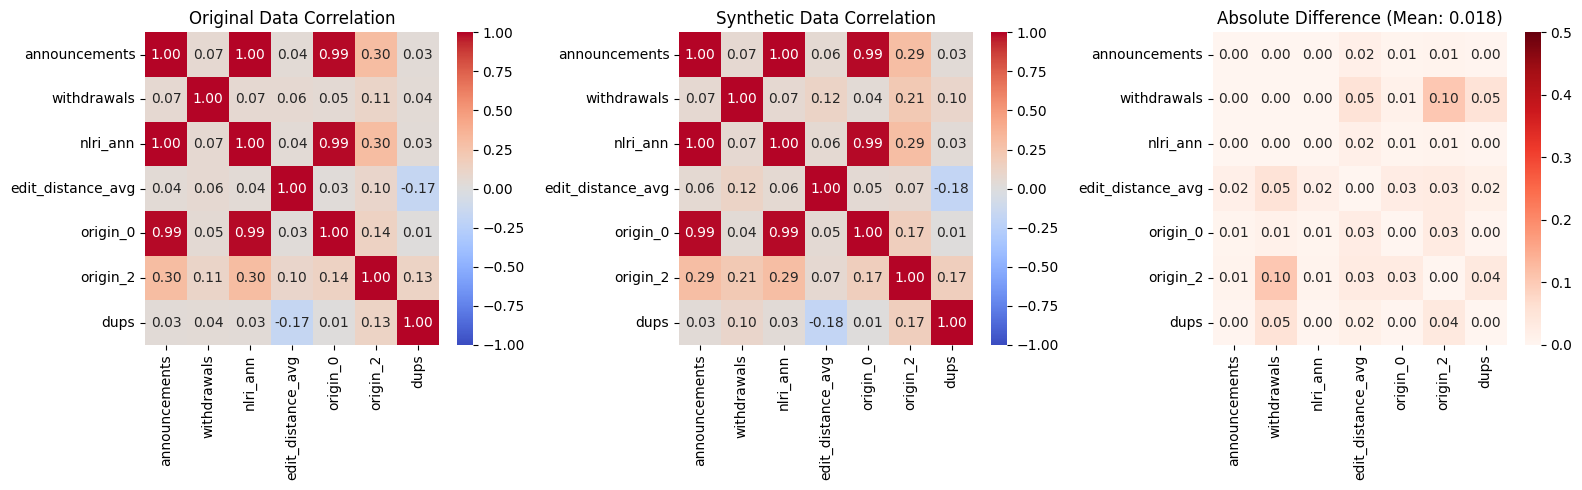

In [34]:
# Plot correlation comparison for best method
print("\nCorrelation Matrix Comparison Plot (Standard SMOTE):")
fig = plot_correlation_comparison(corr_results_smote)
plt.show()


Distribution Comparison Plot (Standard SMOTE vs Original):


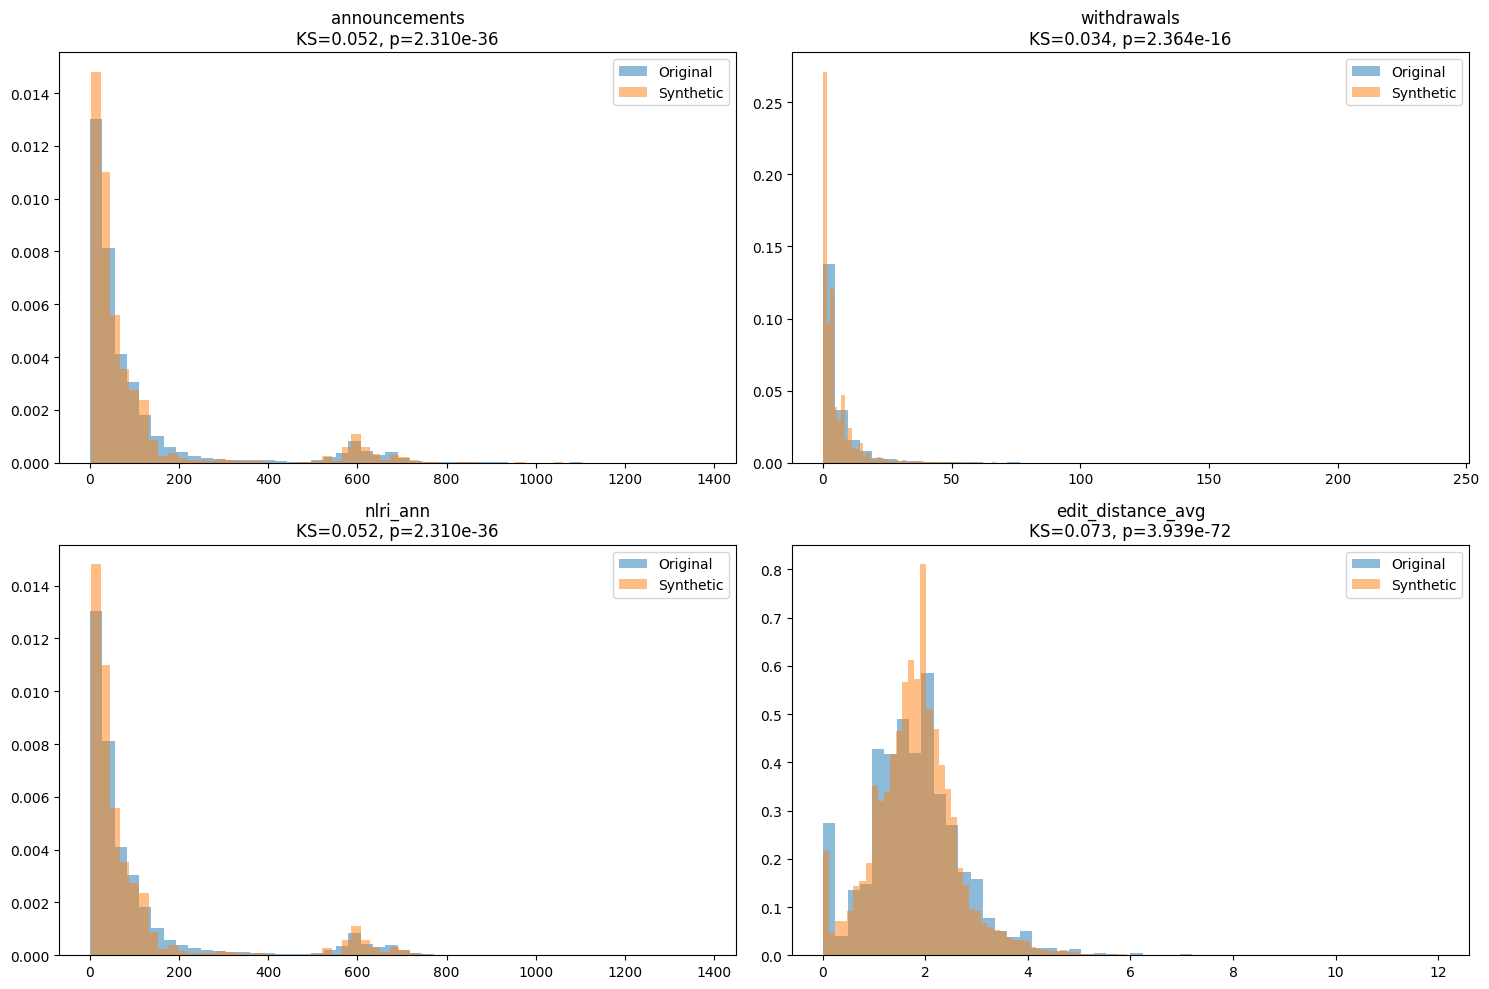

In [35]:
# Plot distribution comparison
print("\nDistribution Comparison Plot (Standard SMOTE vs Original):")
fig = plot_distribution_comparison(X_normal, synthetic_smote)
plt.show()

## 14. Enhanced Statistics Comparison

In [36]:
# Compare all methods with enhanced statistics
stats_smote = compare_statistics_enhanced(X_normal, synthetic_smote, "Enhanced Standard SMOTE")
display(stats_smote[['Feature', 'Orig Mean', 'Synth Mean', 'Mean Diff %', 'KS Stat', 'Quality']].head(10))


Enhanced Comparison: Enhanced Standard SMOTE


,Feature,Orig Mean,Synth Mean,Mean Diff %,KS Stat,Quality
0,announcements,108.67,99.98,8.0%,0.052,Good
1,withdrawals,5.77,4.52,21.7%,0.034,Good
2,nlri_ann,108.67,99.98,8.0%,0.052,Good
3,dups,2.18,1.65,24.4%,0.059,Good
4,origin_0,89.16,82.79,7.2%,0.049,Good
5,origin_2,19.39,17.04,12.2%,0.031,Good
6,origin_changes,3.18,2.98,6.3%,0.039,Good
7,imp_wd,4.64,4.10,11.6%,0.043,Good
8,imp_wd_spath,1.19,0.91,23.4%,0.041,Good
9,imp_wd_dpath,3.45,3.13,9.1%,0.051,Good


In [37]:
stats_borderline = compare_statistics_enhanced(X_normal, synthetic_borderline, "Enhanced Borderline SMOTE")
display(stats_borderline[['Feature', 'Orig Mean', 'Synth Mean', 'Mean Diff %', 'KS Stat', 'Quality']].head(10))


Enhanced Comparison: Enhanced Borderline SMOTE


,Feature,Orig Mean,Synth Mean,Mean Diff %,KS Stat,Quality
0,announcements,108.67,88.40,18.7%,0.123,Fair
1,withdrawals,5.77,4.05,29.8%,0.108,Fair
2,nlri_ann,108.67,88.40,18.7%,0.123,Fair
3,dups,2.18,1.46,32.9%,0.091,Good
4,origin_0,89.16,74.06,16.9%,0.067,Good
5,origin_2,19.39,14.19,26.9%,0.168,Fair
6,origin_changes,3.18,2.86,10.3%,0.052,Good
7,imp_wd,4.64,3.90,15.9%,0.079,Good
8,imp_wd_spath,1.19,0.68,43.2%,0.093,Good
9,imp_wd_dpath,3.45,3.17,7.9%,0.130,Fair


In [38]:
stats_adasyn = compare_statistics_enhanced(X_normal, synthetic_adasyn, "Enhanced ADASYN")
display(stats_adasyn[['Feature', 'Orig Mean', 'Synth Mean', 'Mean Diff %', 'KS Stat', 'Quality']].head(10))


Enhanced Comparison: Enhanced ADASYN


,Feature,Orig Mean,Synth Mean,Mean Diff %,KS Stat,Quality
0,announcements,108.67,97.89,9.9%,0.058,Good
1,withdrawals,5.77,4.45,22.9%,0.038,Good
2,nlri_ann,108.67,97.89,9.9%,0.058,Good
3,dups,2.18,1.63,25.3%,0.061,Good
4,origin_0,89.16,81.10,9.0%,0.053,Good
5,origin_2,19.39,16.64,14.2%,0.037,Good
6,origin_changes,3.18,2.97,6.6%,0.035,Good
7,imp_wd,4.64,4.07,12.4%,0.045,Good
8,imp_wd_spath,1.19,0.91,23.9%,0.042,Good
9,imp_wd_dpath,3.45,3.10,10.0%,0.048,Good


In [39]:
stats_kmeans = compare_statistics_enhanced(X_normal, synthetic_kmeans, "Enhanced K-Means SMOTE")
display(stats_kmeans[['Feature', 'Orig Mean', 'Synth Mean', 'Mean Diff %', 'KS Stat', 'Quality']].head(10))


Enhanced Comparison: Enhanced K-Means SMOTE


,Feature,Orig Mean,Synth Mean,Mean Diff %,KS Stat,Quality
0,announcements,108.67,106.84,1.7%,0.011,Good
1,withdrawals,5.77,4.94,14.4%,0.027,Good
2,nlri_ann,108.67,106.84,1.7%,0.011,Good
3,dups,2.18,2.07,5.3%,0.023,Good
4,origin_0,89.16,87.76,1.6%,0.013,Good
5,origin_2,19.39,18.91,2.5%,0.014,Good
6,origin_changes,3.18,3.02,5.2%,0.021,Good
7,imp_wd,4.64,4.48,3.4%,0.014,Good
8,imp_wd_spath,1.19,1.14,4.4%,0.021,Good
9,imp_wd_dpath,3.45,3.29,4.6%,0.019,Good


## 15. Quality Summary Across Methods

In [40]:
def summarize_quality(stats_df, method_name):
    """Summarize quality metrics for a method."""
    quality_counts = stats_df['Quality'].value_counts()
    return {
        'Method': method_name,
        'Good': quality_counts.get('Good', 0),
        'Fair': quality_counts.get('Fair', 0),
        'Poor': quality_counts.get('Poor', 0),
        'Total Features': len(stats_df)
    }


# Create summary table
quality_summary = pd.DataFrame([
    summarize_quality(stats_smote, 'Enhanced SMOTE'),
    summarize_quality(stats_borderline, 'Enhanced Borderline'),
    summarize_quality(stats_adasyn, 'Enhanced ADASYN'),
    summarize_quality(stats_kmeans, 'Enhanced K-Means')
])

print("\n" + "="*70)
print("Quality Summary Across Methods")
print("="*70)
display(quality_summary)


Quality Summary Across Methods


,Method,Good,Fair,Poor,Total Features
0,Enhanced SMOTE,27,0,0,27
1,Enhanced Borderline,18,9,0,27
2,Enhanced ADASYN,27,0,0,27
3,Enhanced K-Means,27,0,0,27


## 16. Save Synthetic Data

In [41]:
def prepare_output(synthetic_df, method_name, include_validation=True):
    """Prepare synthetic data for output with proper labels and metadata."""
    output_df = synthetic_df.copy()
    output_df['timestamp'] = pd.date_range('2024-01-01', periods=len(output_df), freq='1min')
    output_df['label'] = 'synthetic'
    output_df['discovered_label'] = 'likely_normal_synthetic'
    output_df['generation_method'] = method_name
    output_df['log_transform_used'] = USE_LOG_TRANSFORM
    output_df['bgp_constraints_enforced'] = ENFORCE_BGP_CONSTRAINTS
    return output_df


# Prepare outputs
synthetic_smote_out = prepare_output(synthetic_smote, 'enhanced_smote')
synthetic_borderline_out = prepare_output(synthetic_borderline, 'enhanced_borderline_smote')
synthetic_adasyn_out = prepare_output(synthetic_adasyn, 'enhanced_adasyn')
synthetic_kmeans_out = prepare_output(synthetic_kmeans, 'enhanced_kmeans_smote')

print("Outputs prepared!")

Outputs prepared!


In [46]:
# Save individual method outputs
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/'  # Update as needed

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

synthetic_smote_out.to_csv(f'{OUTPUT_DIR}synthetic_likely_normal_enhanced_smote.csv', index=False)
synthetic_borderline_out.to_csv(f'{OUTPUT_DIR}synthetic_likely_normal_enhanced_borderline.csv', index=False)
synthetic_adasyn_out.to_csv(f'{OUTPUT_DIR}synthetic_likely_normal_enhanced_adasyn.csv', index=False)
synthetic_kmeans_out.to_csv(f'{OUTPUT_DIR}synthetic_likely_normal_enhanced_kmeans.csv', index=False)

print("Individual files saved!")

Individual files saved!


In [47]:
# Combined output with all methods
combined_synthetic = pd.concat([
    synthetic_smote_out,
    synthetic_borderline_out,
    synthetic_adasyn_out,
    synthetic_kmeans_out
], ignore_index=True)

combined_synthetic.to_csv(f'{OUTPUT_DIR}synthetic_likely_normal_all_enhanced_methods.csv', index=False)

print(f"Combined file saved with {len(combined_synthetic)} total samples!")

Combined file saved with 80172 total samples!


In [48]:
# Save validation results
validation_results = {
    'ks_tests': {
        'smote': ks_results_smote.to_dict(),
        'kmeans': ks_results_kmeans.to_dict()
    },
    'correlation_metrics': {
        'smote': {
            'frobenius_norm': corr_results_smote['frobenius_norm'],
            'max_diff': corr_results_smote['max_diff'],
            'mean_diff': corr_results_smote['mean_diff']
        },
        'kmeans': {
            'frobenius_norm': corr_results_kmeans['frobenius_norm'],
            'max_diff': corr_results_kmeans['max_diff'],
            'mean_diff': corr_results_kmeans['mean_diff']
        }
    },
    'quality_summary': quality_summary.to_dict()
}

import json
with open(f'{OUTPUT_DIR}validation_results.json', 'w') as f:
    json.dump(validation_results, f, indent=2, default=str)

print("Validation results saved!")

Validation results saved!


In [49]:
# Summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nOriginal 'likely_normal' samples: {len(X_normal)}")
print(f"Features used: {len(ALL_FEATURES)}")
print(f"\nEnhancements Applied:")
print(f"  - Log1p transform for heavy-tailed features: {USE_LOG_TRANSFORM}")
print(f"  - BGP semantic constraints enforcement: {ENFORCE_BGP_CONSTRAINTS}")
print(f"  - k_neighbors validation: Yes")
print(f"  - Empirical bounds clipping: Yes")
print(f"\nSynthetic samples generated:")
print(f"  - Enhanced SMOTE:           {len(synthetic_smote)}")
print(f"  - Enhanced Borderline:      {len(synthetic_borderline)}")
print(f"  - Enhanced ADASYN:          {len(synthetic_adasyn)}")
print(f"  - Enhanced K-Means:         {len(synthetic_kmeans)}")
print(f"  - Total:                    {len(combined_synthetic)}")
print(f"\nDistributional Validation:")
print(f"  - KS Tests performed: Yes")
print(f"  - Correlation comparison: Yes")
print(f"\nFiles saved:")
print(f"  - synthetic_likely_normal_enhanced_smote.csv")
print(f"  - synthetic_likely_normal_enhanced_borderline.csv")
print(f"  - synthetic_likely_normal_enhanced_adasyn.csv")
print(f"  - synthetic_likely_normal_enhanced_kmeans.csv")
print(f"  - synthetic_likely_normal_all_enhanced_methods.csv")
print(f"  - validation_results.json")


SUMMARY

Original 'likely_normal' samples: 67940
Features used: 27

Enhancements Applied:
  - Log1p transform for heavy-tailed features: True
  - BGP semantic constraints enforcement: True
  - k_neighbors validation: Yes
  - Empirical bounds clipping: Yes

Synthetic samples generated:
  - Enhanced SMOTE:           20000
  - Enhanced Borderline:      20000
  - Enhanced ADASYN:          20178
  - Enhanced K-Means:         19994
  - Total:                    80172

Distributional Validation:
  - KS Tests performed: Yes
  - Correlation comparison: Yes

Files saved:
  - synthetic_likely_normal_enhanced_smote.csv
  - synthetic_likely_normal_enhanced_borderline.csv
  - synthetic_likely_normal_enhanced_adasyn.csv
  - synthetic_likely_normal_enhanced_kmeans.csv
  - synthetic_likely_normal_all_enhanced_methods.csv
  - validation_results.json
